# Ужасы линейной регрессии

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
np.random.seed(42)

# Разминка
1) Какие признаки может обработать линейная регрессия?
2) Почему нет понятия полиномиальных моделей?
3) Вам дан набор данных из 8 элементов. Вы используете стохастический градиентный спуск с батчем 8. Сколько шагов нужно сделать, чтобы пройти весь набор данных?
4) Вам нужно предсказать, к какой категории относится товар. Всего категорий 100. Как лучше решать такую задачу - через регрессию или классификацию?
5) Вам нужно предсказать, в каком часу была сделана покупка некоторого товара. Вы решили использовать для этого регрессию. Расскажите, как вы будете решать эту задачу. Как вы сформируете таргет? Как будете выдавать предсказания на инференсе?
6) Как выглядит точное решение задачи линейной регрессии (нормальная форма)?

# База
Напомню, что линейная регрессия - это модель следующего вида:
    $$a(x) = \langle w, x \rangle + w_0$$,
    где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. 
Обучить линейную регрессию - значит найти $w$ и $w_0$., минимизирующие разницу между предсказанными значениями  $y'$ и  $y$.

# Ловушки в данных

Рассмотрим набор данных, состоящий из 2 разных предикторов и четырех таргетов. Этот набор специально создан, чтобы показать важность анализа данных даже в, казалось бы, простой ситуации. Построим 4 разные модели по парам (x123, y1), (x123, y2),(x123, y3), (x4, y4).

In [3]:
data_path = "A:\educ\ml-sem6\data"

In [4]:
quartet_df = pd.read_csv(f"{data_path}/Anscombe_quartet_data.csv")

Для начала рассмотрим значения корреляций между признаками и таргетами

In [5]:
def corrplot(d: pd.DataFrame) -> None:
  corr = d.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  figsize = (min(d.shape[1], 11), min(d.shape[1], 9))
  f, ax = plt.subplots(figsize=figsize)
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

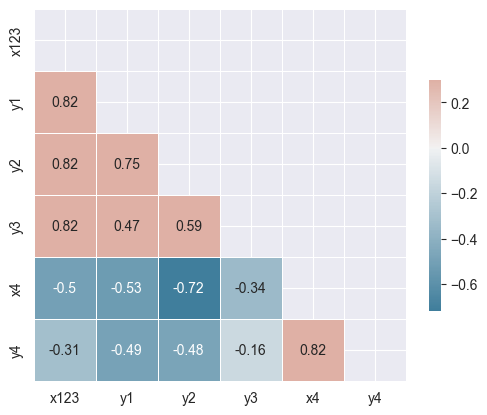

In [6]:
corrplot(quartet_df)

Как видно, корреляции одинаковы. Однако, если построить модели и графики предсказаний, результаты будут знгачительно отличаться.
ЭТакже выведем значения коэффициентов модели.

**Задание**: Постройте линейные модели для каждого из наборов данных, не смотря на графики. Отличаются ли модели?

In [7]:
def fit_and_plot_anscombe(x_series, y_series, title):
    x = np.array(x_series).reshape((-1, 1))
    y = np.array(y_series)
    model = LinearRegression().fit(
        x, y
    )
    y_pred = model.predict(x)
    r_sq = model.score(x, y)
    
    print(f"{title}")
    print(f"R²: {r_sq:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"Slope: {model.coef_[0]:.4f}\n")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color="green", alpha=0.7)
    plt.plot(x, y_pred, color="blue", linewidth=2)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return model

Anscombe 1
R²: 0.6665
Intercept: 3.0001
Slope: 0.5001



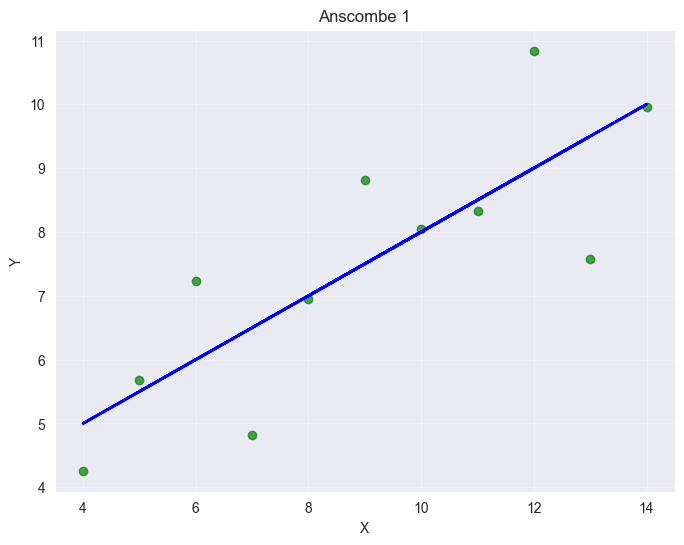

LinearRegression()

In [8]:
fit_and_plot_anscombe(quartet_df['x123'], quartet_df['y1'], "Anscombe 1")

Anscombe 2
R²: 0.6662
Intercept: 3.0009
Slope: 0.5000



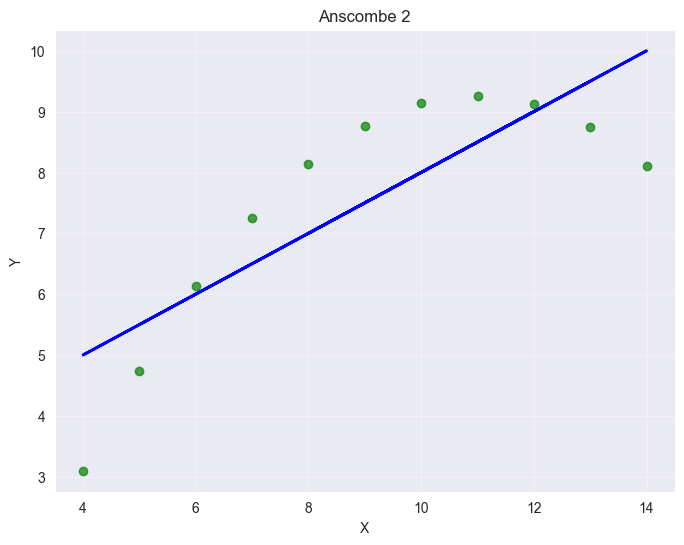

LinearRegression()

In [9]:
# Anscombe 2
fit_and_plot_anscombe(quartet_df['x123'], quartet_df['y2'], "Anscombe 2")

Anscombe 3
R²: 0.6663
Intercept: 3.0025
Slope: 0.4997



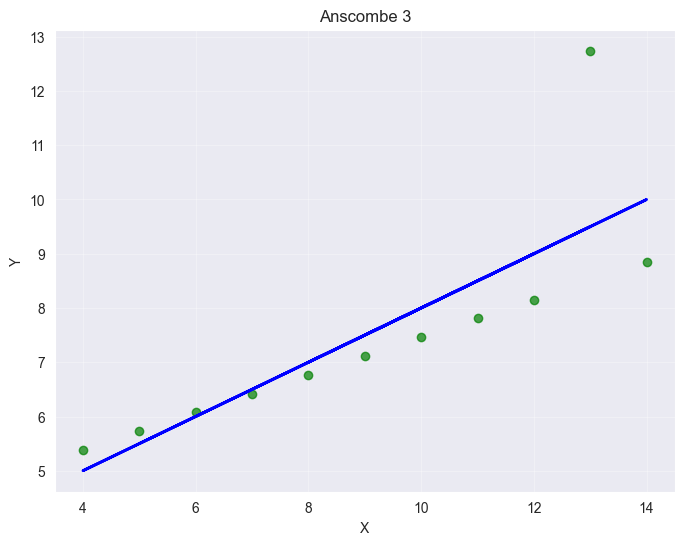

LinearRegression()

In [10]:
fit_and_plot_anscombe(quartet_df['x123'], quartet_df['y3'], "Anscombe 3")

Anscombe 4
R²: 0.6667
Intercept: 3.0017
Slope: 0.4999



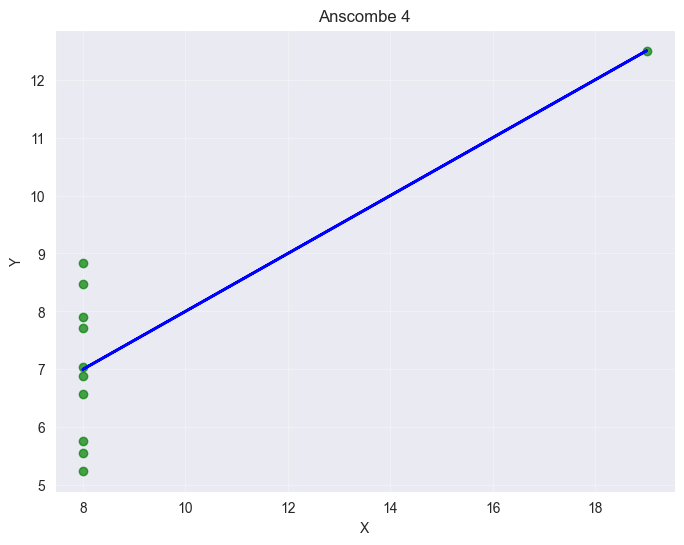

LinearRegression()

In [11]:
fit_and_plot_anscombe(quartet_df['x4'], quartet_df['y4'], "Anscombe 4")

Как видно, все эти зависимости имеют разную природу, но при этом порождают модели с практически одинаковыми параметрами. Таким образом, чрезвычайно важно проводить достаточно объемный EDA.
Датасет же - известный набор [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)

# Положения линейной регрессии
Далее рассмотрим некоторые положения линейной регрессии, которые задают границы ее применимости (а также что бывает, когда они нарушаются).

**Линейность**: взаимосвязь между зависимыми и независимыми переменными линейна.

**Независимость**: Наблюдения независимы друг от друга.

**Гомоскедастичность**: дисперсия ошибок постоянна на всех уровнях независимых переменных.

**Нормальность**: ошибки подчиняются нормальному распределению.

**Нет мультиколлинеарности**: независимые переменные не сильно коррелируют друг с другом.

**Нет эндогенности**: между ошибками и независимыми переменными нет связи.

## Нелинейность

Рассмотрим набор данных Bluegills.
В 1981 году n = 78 [cинежаберных солнечников](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BD%D0%B5%D0%B6%D0%B0%D0%B1%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D1%81%D0%BE%D0%BB%D0%BD%D0%B5%D1%87%D0%BD%D0%B8%D0%BA) были случайным образом отобраны из озера Мэри в Миннесоте (Кук и Вайсберг, 1999):
* Длина (в мм) рыбы
* Возраст (в годах) рыбы


In [12]:
df = pd.read_csv(f"{data_path}/bluegills.txt", sep="\t")

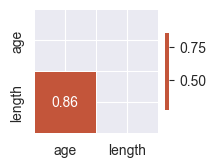

In [13]:
corrplot(df)

<Axes: xlabel='age', ylabel='length'>

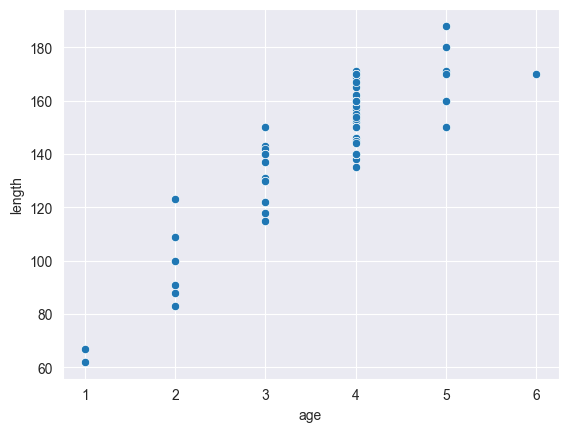

In [14]:
sns.scatterplot(df, x="age", y="length")

График позволяет предположить, что в данных наблюдается положительная динамика. Неудивительно, что с увеличением возраста рыб их длина имеет тенденцию к увеличению. Однако эта тенденция не выглядит вполне линейной. Кажется, что отношения слегка искривлены.

Один из способов моделирования кривизны этих данных — сформулировать «полиномиальную модель второго порядка»:

$ Y=\beta_0+ \sum_i (\alpha_i  X_i^2) + \sum_i (\beta_i  X_i) + \sum_{j \neq i} (\gamma_{ij}  X_i X_j) + \epsilon $

Сделать это просто, введя в данные полиномиальные признаки (PolynomialFeatures) и обучив обычную линейную модель.

In [15]:
X = np.array(df["age"]).reshape(-1, 1)
y =np.array(df["length"])
model_basic = LinearRegression()
model_basic.fit(X, df["length"])
y_basic = model_basic.predict(X)

In [16]:
degree = 2  # Set the polynomial degree
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X=np.array(df.loc[:,"age"]).reshape(-1, 1))
X = np.array(df["age"]).reshape(-1, 1)
y =np.array(df["length"])
model_basic = LinearRegression()
model_basic.fit(X, df["length"])
model_poly = LinearRegression()
model_poly.fit(X_poly,  df["length"])
y_basic = model_basic.predict(X)
y_poly = model_poly.predict(X_poly)

In [17]:
print(f"coefficient of determination of linear model: {model_basic.score(X, y)}")
print(f"coefficient of determination of polynomial model: {model_poly.score(X_poly, y)}")

coefficient of determination of linear model: 0.7348821471782518
coefficient of determination of polynomial model: 0.8011378030846004


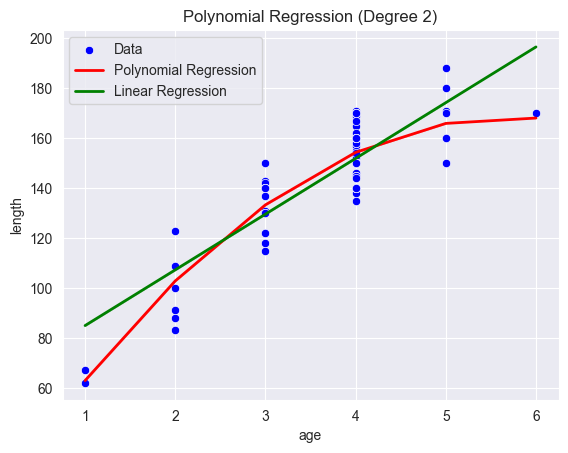

In [18]:
sns.scatterplot(df,x="age", y="length", label='Data', color='blue')
sns.lineplot(x=df["age"], y=y_poly, label='Polynomial Regression', color='red', linewidth=2)
sns.lineplot(x=df["age"], y=y_basic, label='Linear Regression', color='green', linewidth=2)
plt.xlabel('age')
plt.ylabel('length')
plt.legend()
plt.title(f'Polynomial Regression (Degree {degree})')
plt.show()

**Задание**: Постройте модель для наборов Anscombe 1 и Anscombe 2. Напишите, какие степени полинома подойдут лучше всего.

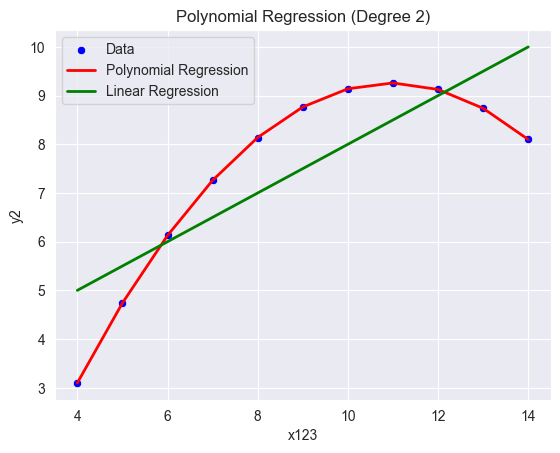

coefficient of determination of linear model: 0.6662420337274844
coefficient of determination of polynomial model: 0.999999457857722


In [24]:
#x123 y2 ans 2 - deg2
#x123 y1 ans 1 - deg3
X = np.array(quartet_df["x123"]).reshape(-1, 1)
y =np.array(quartet_df["y2"])
model_basic = LinearRegression()
model_basic.fit(X, quartet_df["y2"])
y_basic = model_basic.predict(X)

degree = 2  # Set the polynomial degree
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X=np.array(quartet_df.loc[:,"x123"]).reshape(-1, 1))
X = np.array(quartet_df["x123"]).reshape(-1, 1)
y =np.array(quartet_df["y2"])
model_basic = LinearRegression()
model_basic.fit(X, quartet_df["y2"])
model_poly = LinearRegression()
model_poly.fit(X_poly,  quartet_df["y2"])
y_basic = model_basic.predict(X)
y_poly = model_poly.predict(X_poly)

sns.scatterplot(quartet_df,x="x123", y="y2", label='Data', color='blue')
sns.lineplot(x=quartet_df["x123"], y=y_poly, label='Polynomial Regression', color='red', linewidth=2)
sns.lineplot(x=quartet_df["x123"], y=y_basic, label='Linear Regression', color='green', linewidth=2)
plt.xlabel('x123')
plt.ylabel('y2')
plt.legend()
plt.title(f'Polynomial Regression (Degree {degree})')
plt.show()
print(f"coefficient of determination of linear model: {model_basic.score(X, y)}")
print(f"coefficient of determination of polynomial model: {model_poly.score(X_poly, y)}")

Здесь через точки отлично невооружённым взглядом рисовалась парабола - и встала она идеально.

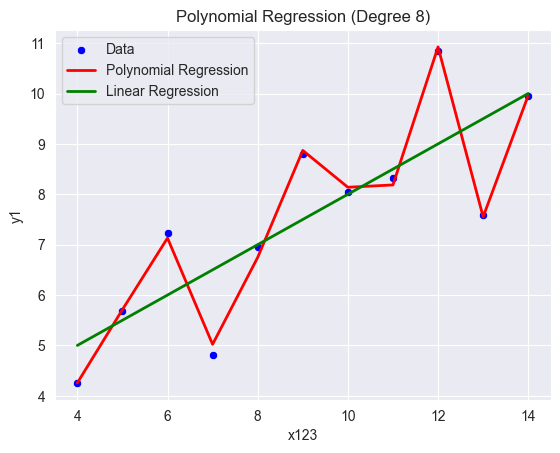

coefficient of determination of linear model: 0.6665424595087748
coefficient of determination of polynomial model: 0.9966821264642685


'\nквадрат - 0.687\nкуб - 0.6887\n4ст - 0.6895\n5ст - 0.7548\n6ст - 0.7586\n7ст - 0.7804\n\n'

In [32]:
#x123 y2 ans 2 - deg2
#x123 y1 ans 1 - deg3
X = np.array(quartet_df["x123"]).reshape(-1, 1)
y =np.array(quartet_df["y1"])
model_basic = LinearRegression()
model_basic.fit(X, quartet_df["y1"])
y_basic = model_basic.predict(X)

degree = 8  # Set the polynomial degree
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X=np.array(quartet_df.loc[:,"x123"]).reshape(-1, 1))
X = np.array(quartet_df["x123"]).reshape(-1, 1)
y =np.array(quartet_df["y1"])
model_basic = LinearRegression()
model_basic.fit(X, quartet_df["y1"])
model_poly = LinearRegression()
model_poly.fit(X_poly,  quartet_df["y1"])
y_basic = model_basic.predict(X)
y_poly = model_poly.predict(X_poly)

sns.scatterplot(quartet_df,x="x123", y="y1", label='Data', color='blue')
sns.lineplot(x=quartet_df["x123"], y=y_poly, label='Polynomial Regression', color='red', linewidth=2)
sns.lineplot(x=quartet_df["x123"], y=y_basic, label='Linear Regression', color='green', linewidth=2)
plt.xlabel('x123')
plt.ylabel('y1')
plt.legend()
plt.title(f'Polynomial Regression (Degree {degree})')
plt.show()
print(f"coefficient of determination of linear model: {model_basic.score(X, y)}")
print(f"coefficient of determination of polynomial model: {model_poly.score(X_poly, y)}")
"""
квадрат - 0.687
куб - 0.6887
4ст - 0.6895
5ст - 0.7548
6ст - 0.7586
7ст - 0.7804
8ст (по кол-ву точек) - 0.997
"""

Чем больше степень, тем больше вычислять. И, вероятно, с ростом степени растёт склонность к переобучению. Ощутимый скачок наблюдается в пятой степени - можно взять её основной, но без тестовой выборки сказать сложно.

**Задание со звездочкой**: Постройте модель с использованием другого базиса, не полиномиального. Проиллюстрируйте ее применение на примерах из практики.

## Выбросы
Как мы уже видели, выбросы могут сильно влиять на предсказания линейной модели. Даже один выброс может нарушить одно из условий линейной регрессии. К счастью, существует много сапособов с ними бороться.
Простейший вариант - использовать не MSE, а MAE. Почему?
Однако есть и более сложные варианты. Например, комбинация MSE и MAE дает **HuberLoss**:

$$L_\delta(r) = \begin{cases}
\frac{1}{2}r^2 & \text{если } |r| \leq \delta \\
\delta|r| - \frac{1}{2}\delta^2 & \text{если } |r| > \delta
\end{cases}$$

где $r = y_i - \mathbf{x}_i^T \beta$ — остаток, $\delta$ — параметр переключения.

- При малых ошибках ($|r| \leq \delta$) ведет себя как OLS
- При больших ошибках ($|r| > \delta$) ведет себя как MAE 


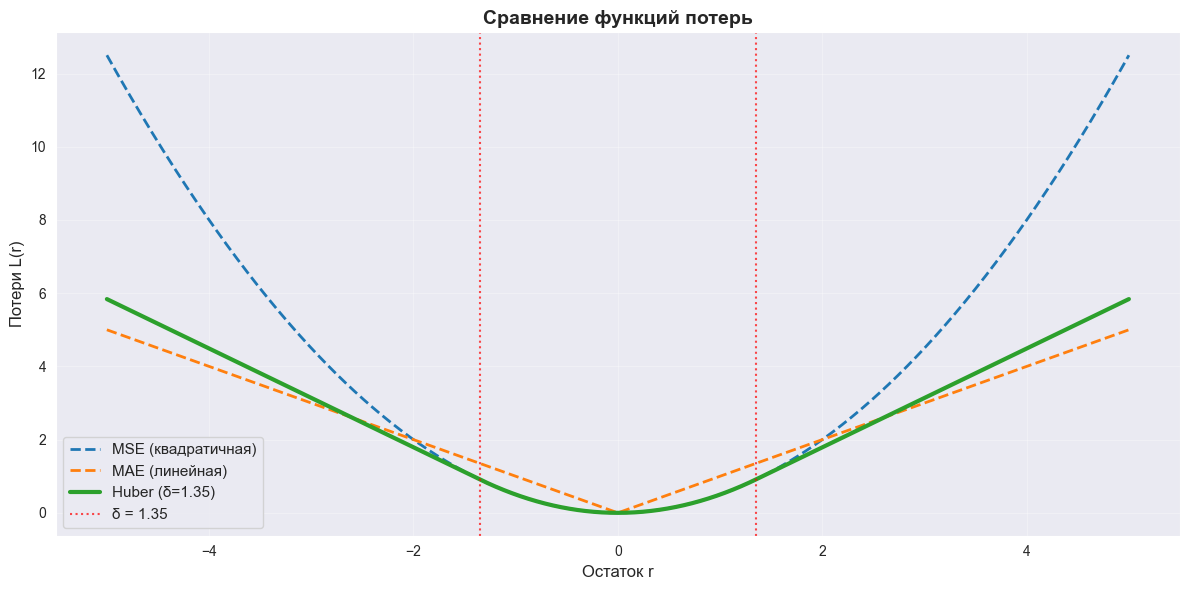

In [33]:
# Визуализация функции потерь Huber
def huber_loss(r, delta):
    """Вычисляет функцию потерь Huber."""
    return np.where(np.abs(r) <= delta, 0.5 * r**2, delta * np.abs(r) - 0.5 * delta**2)

r = np.linspace(-5, 5, 1000)
delta = 1.35

mse_loss = 0.5 * r**2
mae_loss = np.abs(r)
huber = huber_loss(r, delta)

plt.figure(figsize=(12, 6))
plt.plot(r, mse_loss, label='MSE (квадратичная)', linewidth=2, linestyle='--')
plt.plot(r, mae_loss, label='MAE (линейная)', linewidth=2, linestyle='--')
plt.plot(r, huber, label=f'Huber (δ={delta})', linewidth=3)
plt.axvline(x=delta, color='red', linestyle=':', alpha=0.7, label=f'δ = {delta}')
plt.axvline(x=-delta, color='red', linestyle=':', alpha=0.7)
plt.xlabel('Остаток r', fontsize=12)
plt.ylabel('Потери L(r)', fontsize=12)
plt.title('Сравнение функций потерь', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


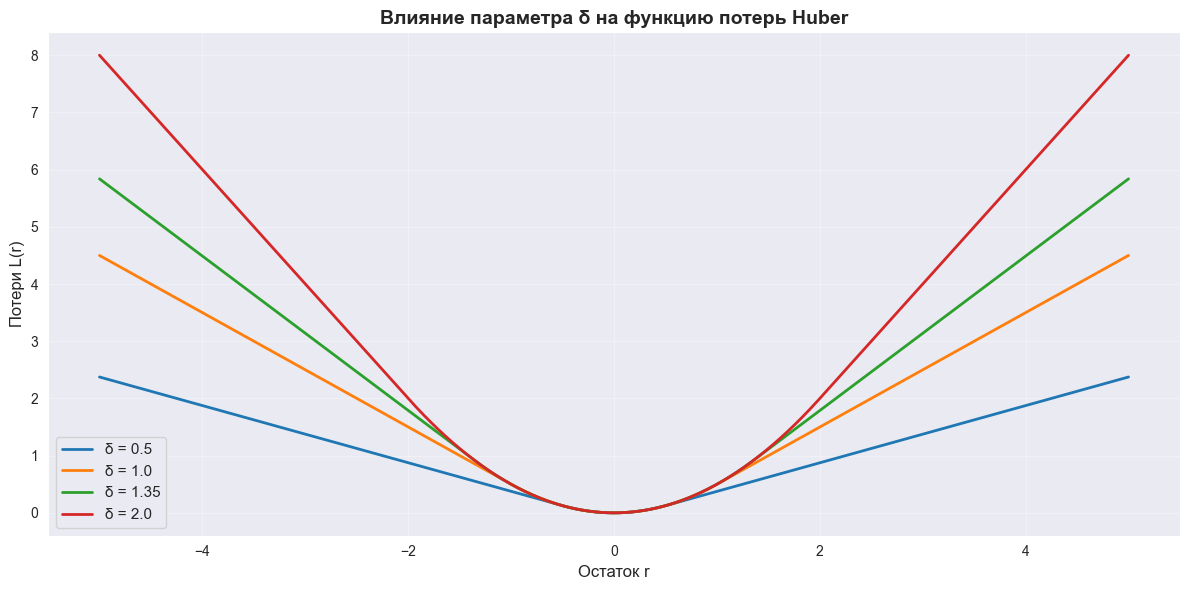

In [34]:
# Влияние параметра delta на функцию потерь
deltas = [0.5, 1.0, 1.35, 2.0]
r = np.linspace(-5, 5, 1000)

plt.figure(figsize=(12, 6))
for delta in deltas:
    huber = huber_loss(r, delta)
    plt.plot(r, huber, label=f'δ = {delta}', linewidth=2)

plt.xlabel('Остаток r', fontsize=12)
plt.ylabel('Потери L(r)', fontsize=12)
plt.title('Влияние параметра δ на функцию потерь Huber', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Другой робастный вариант - **Theil-Sen regression**. Этот метод строит медиану наклона модели между всеми парами наблюдений. Метод непараметрический. Проблема этого метода в том, что для больших наборов данных вычислительная сложность метода становится слишком большой ($O(n^2)$ для наклона, $O(n \log n)$ для медианы):

**Алгоритм**:
1. Для всех пар точек $(x_i, y_i)$ и $(x_j, y_j)$, где $i < j$, вычисляется наклон:
   $$b_{ij} = \frac{y_j - y_i}{x_j - x_i}$$
2. Оценка наклона: $\hat{\beta}_1 = \text{median}(\{b_{ij}\})$
3. Оценка свободного члена: $\hat{\beta}_0 = \text{median}(\{y_i - \hat{\beta}_1 x_i\})$

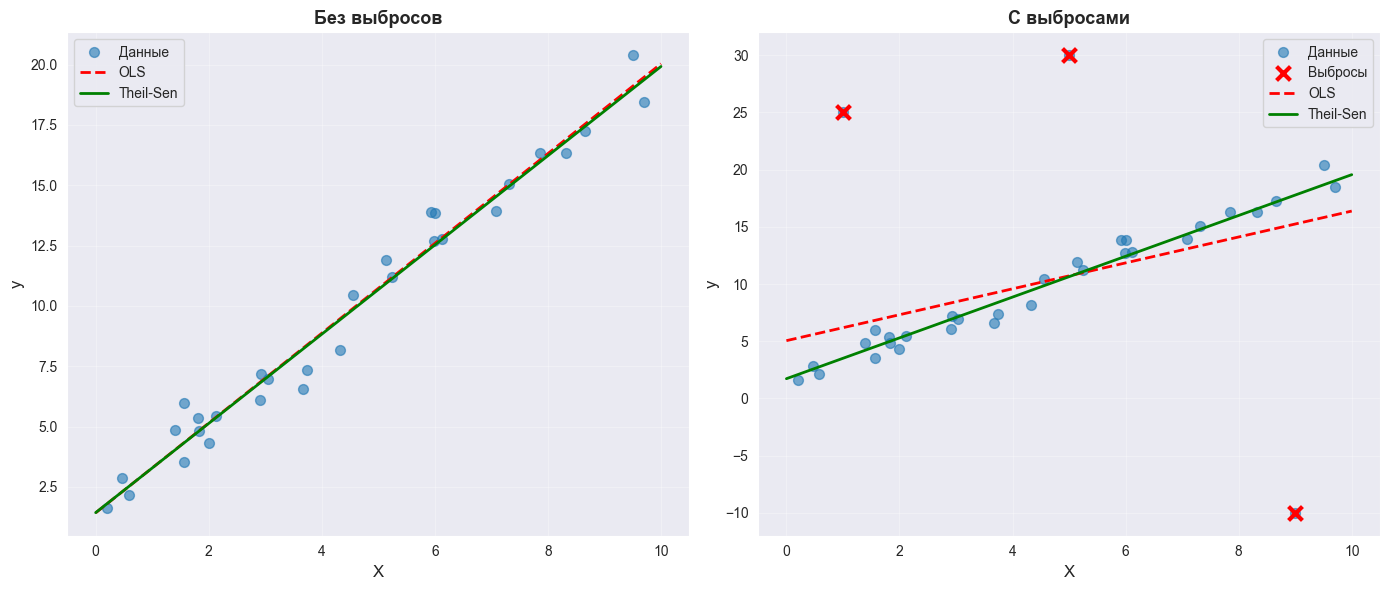

In [35]:
# Иллюстрация работы Theil-Sen
np.random.seed(42)
n = 30
X_clean = np.random.uniform(0, 10, n)
y_clean = 2 * X_clean + 1 + np.random.normal(0, 1, n)

# Добавляем выбросы
X_outliers = np.append(X_clean, [1, 9, 5])
y_outliers = np.append(y_clean, [25, -10, 30])

# OLS
ols = LinearRegression()
ols.fit(X_clean.reshape(-1, 1), y_clean)
ols_outliers = LinearRegression()
ols_outliers.fit(X_outliers.reshape(-1, 1), y_outliers)

# Theil-Sen
theil = TheilSenRegressor(random_state=42)
theil.fit(X_clean.reshape(-1, 1), y_clean)
theil_outliers = TheilSenRegressor(random_state=42)
theil_outliers.fit(X_outliers.reshape(-1, 1), y_outliers)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Без выбросов
axes[0].scatter(X_clean, y_clean, alpha=0.6, s=50, label='Данные')
x_plot = np.linspace(0, 10, 100)
axes[0].plot(x_plot, ols.predict(x_plot.reshape(-1, 1)), 'r--', linewidth=2, label='OLS')
axes[0].plot(x_plot, theil.predict(x_plot.reshape(-1, 1)), 'g-', linewidth=2, label='Theil-Sen')
axes[0].set_xlabel('X', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title('Без выбросов', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# С выбросами
axes[1].scatter(X_outliers, y_outliers, alpha=0.6, s=50, label='Данные')
axes[1].scatter([1, 9, 5], [25, -10, 30], color='red', s=100, marker='x', linewidths=3, label='Выбросы')
axes[1].plot(x_plot, ols_outliers.predict(x_plot.reshape(-1, 1)), 'r--', linewidth=2, label='OLS')
axes[1].plot(x_plot, theil_outliers.predict(x_plot.reshape(-1, 1)), 'g-', linewidth=2, label='Theil-Sen')
axes[1].set_xlabel('X', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].set_title('С выбросами', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Третий метод: **RANSAC**. Его идея в том, чтобы сначала построить много моделей-кандидатов, а потом выбрать из них лучшую.

**Алгоритм**:
1. Случайно выбирается минимальная подвыборка для оценки параметров (для линейной регрессии — 2 точки)
2. На подвыборке строится модель
3. Вычисляются остатки для всех точек. Точки с остатками меньше порога $t$ считаются inliers (внутренними)
4. Если количество inliers достаточно велико, модель переоценивается на всех inliers
5. Шаги 1-4 повторяются $N$ раз
6. Выбирается модель с наибольшим количеством inliers

Вероятность того, что на всех итерациях до $N$ хотя бы 1 точка будет выбросом (то есть построится некорректная модель) $(1-q)^N$, где q - доля выбросов. Таким образом, мы можем примерно оценить, сколько нам потребуется итераций, а метод становится наиболее толерантным к числу выбросов. Минус в том, что верхняя граница числа итераций фактически не задана, а наша оценка может быть недостаточной.

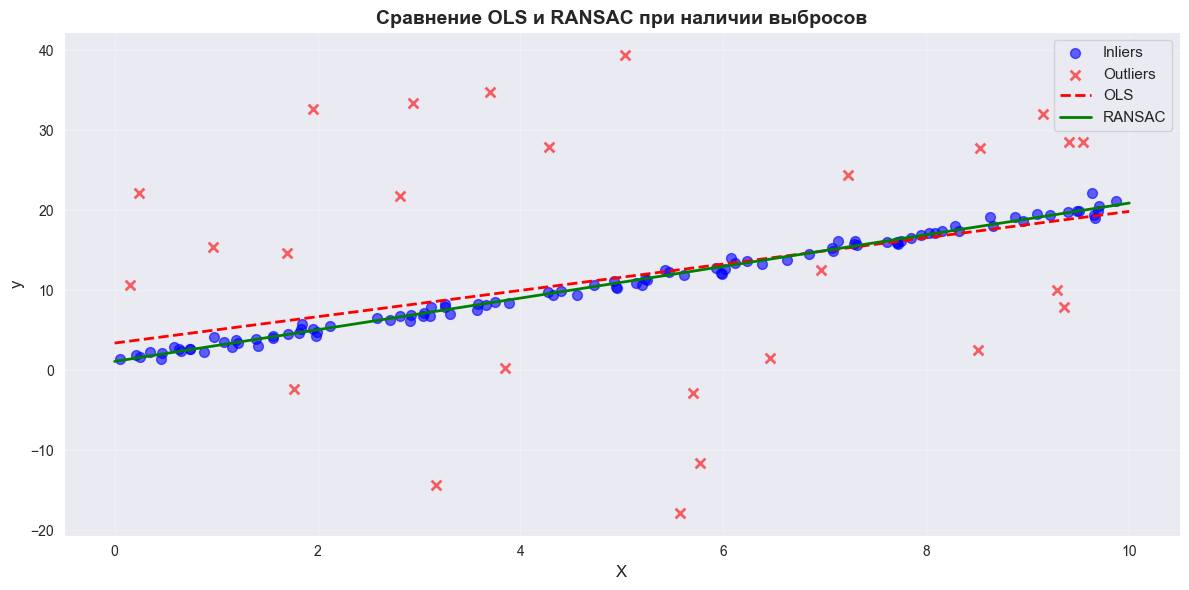

Количество inliers: 104
Количество outliers: 26


In [36]:
# Иллюстрация работы RANSAC
np.random.seed(42)
n = 100
X = np.random.uniform(0, 10, n)
y = 2 * X + 1 + np.random.normal(0, 0.5, n)

# Добавляем выбросы
n_outliers = 30
X_outliers = np.append(X, np.random.uniform(0, 10, n_outliers))
y_outliers = np.append(y, np.random.uniform(-20, 40, n_outliers))

# Модели
ols = LinearRegression()
ols.fit(X_outliers.reshape(-1, 1), y_outliers)

ransac = RANSACRegressor(random_state=42, residual_threshold=2.0, max_trials=100)
ransac.fit(X_outliers.reshape(-1, 1), y_outliers)

# Разделение на inliers и outliers
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Визуализация
plt.figure(figsize=(12, 6))
x_plot = np.linspace(0, 10, 100)

plt.scatter(X_outliers[inlier_mask], y_outliers[inlier_mask], 
           color='blue', alpha=0.6, s=50, label='Inliers')
plt.scatter(X_outliers[outlier_mask], y_outliers[outlier_mask], 
           color='red', alpha=0.6, s=50, marker='x', linewidths=2, label='Outliers')
plt.plot(x_plot, ols.predict(x_plot.reshape(-1, 1)), 'r--', linewidth=2, label='OLS')
plt.plot(x_plot, ransac.predict(x_plot.reshape(-1, 1)), 'g-', linewidth=2, label='RANSAC')
plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Сравнение OLS и RANSAC при наличии выбросов', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Количество inliers: {np.sum(inlier_mask)}")
print(f"Количество outliers: {np.sum(outlier_mask)}")



Почему мы захотим применять тот или иной метод, зависит от наших требований (на скорость обучения, например) и толерантности к выбросам, которую мы можем себе позволить.

**Breakdown point** (точка разрушения) — минимальная доля выбросов, которая может сделать оценку сколь угодно плохой (то есть изменение параметров перестает быть ограниченным при добавлении следующих выбросов).

- OLS: breakdown point = 0% (один выброс может разрушить оценку)
- Медианная регрессия: breakdown point = 50%
- Theil-Sen: breakdown point ≈ 29.3%
- RANSAC: зависит от параметров, обычно 30-50%
- Huber: breakdown point зависит от параметра $\epsilon$, обычно 10-20%


Рассмотрим синтетические данные. Пусть это будут синусоидальные данные, но некоторые наблюдения будут "испорчены"

In [37]:
X = np.random.uniform(0, 1.5, size=300)
y = np.sin(1.5 * np.pi * X) + np.random.normal(scale=0.1, size=X.shape)
X = X.reshape(-1,1)

X_test = np.random.uniform(0, 1.5, size=300) 
y_test = np.sin(1.5 * np.pi * X_test) + np.random.normal(scale=0.1, size=X_test.shape)
X_test = X_test.reshape(-1,1)

y_errors = y.copy()
y_errors[::5] = 3

X_errors = X.copy()
X_errors[::5] = 3

y_errors_large = y.copy()
y_errors_large[::5] = 10

X_errors_large = X.copy()
X_errors_large[::5] = 10

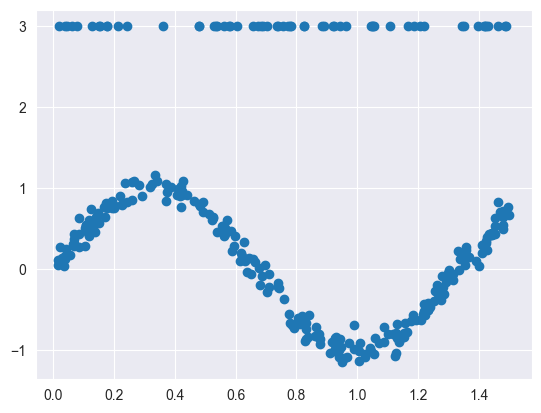

In [38]:
plt.scatter(X, y_errors)

Задание: Последовательно постройте различные модели для разных видов испорченности данных.

C:\Users\Roman\AppData\Local\Temp\ipykernel_12876\3088699241.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  errors_df = pd.concat([errors_df,pd.DataFrame.from_dict(data=errors_dict)])


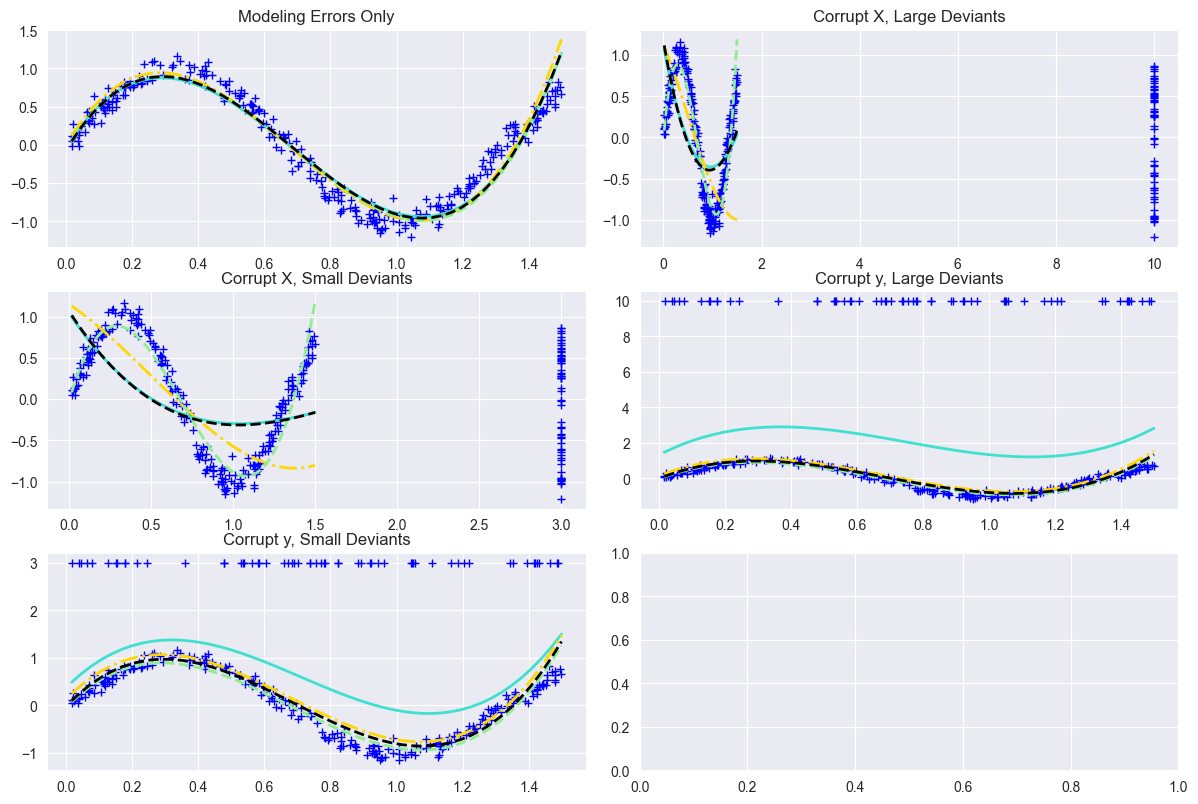

In [39]:
estimators = {
    "OLS": LinearRegression(),
    "Theil-Sen": TheilSenRegressor(random_state=42),
    "RANSAC": RANSACRegressor(random_state=42),
    "Huber": HuberRegressor(),
}

colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}
linestyle = {"OLS": "-", "Theil-Sen": "-.", "RANSAC": "--", "Huber": "--"}
lw = 2
fig, ax = plt.subplots(nrows=3, ncols=2, figsize= (12,8))
fig.tight_layout()
x_plot = np.linspace(X.min(), X.max())
time_dict = {name: 0. for name in estimators.keys()}
errors_df = pd.DataFrame(columns = list(estimators.keys()))
time_dict["Problem"] = "Sum time"
for i, (title, this_X, this_y) in enumerate([
    ("Modeling Errors Only", X, y),
    ("Corrupt X, Small Deviants", X_errors, y),
    ("Corrupt y, Small Deviants", X, y_errors),
    ("Corrupt X, Large Deviants", X_errors_large, y),
    ("Corrupt y, Large Deviants", X, y_errors_large),
]):
    ax[i % 3, i // 3].plot(this_X[:, 0], this_y, "b+")
    errors_dict = {"Problem": title}
    for name, estimator in estimators.items():
        model = make_pipeline(PolynomialFeatures(3), estimator)
        t0 = time.time()
        model.fit(this_X, this_y)
        time_dict[name] += time.time() - t0
        mse = mean_squared_error(model.predict(X_test), y_test)
        errors_dict[name] = [mse]
        y_plot = model.predict(x_plot[:, np.newaxis])
        ax[i % 3, i // 3].plot(
            x_plot,
            y_plot,
            color=colors[name],
            linestyle=linestyle[name],
            linewidth=lw,
            label="%s: error = %.3f" % (name, mse),
        )
    errors_df = pd.concat([errors_df,pd.DataFrame.from_dict(data=errors_dict)])
    ax[i % 3, i // 3].title.set_text(title)
errors_df = pd.concat([errors_df, pd.DataFrame(time_dict, index=[0])]) 
plt.show()

In [40]:
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}

In [41]:
errors_df

,OLS,Theil-Sen,RANSAC,Huber,Problem
0,0.036775,0.037749,0.038612,0.036871,Modeling Errors Only
0,0.322312,0.386310,0.036502,0.321699,"Corrupt X, Small Deviants"
0,0.395312,0.061665,0.035835,0.039736,"Corrupt y, Small Deviants"
0,0.297509,0.447126,0.036502,0.297321,"Corrupt X, Large Deviants"
0,4.050281,0.070167,0.035835,0.039737,"Corrupt y, Large Deviants"
0,0.007126,1.734367,0.086831,0.098090,Sum time


**Задание**: Поиграйте с этими датасетами и параметрами моделей. 
Ответьте на вопросы:
- При каких размерах датасетов лучше использовать каждый из алгоритмов
- При каких процентах выбросов и их значениях лучше использовать каждый из алгоритмов
- Влияет ли то, как распределены выбросы, на выбор метода
- Влияет ли отношение шума к сигналу на выбор алгоритма
- Какие алгоритмы более чувствительны к параметрам, какие менее
Для ответов покажите таблицы и/или графики

## Гетероскедастичность

**Гетероскедастичность** (heteroscedasticity) — это ситуация, когда дисперсия ошибок регрессионной модели не является постоянной для всех наблюдений. 

В классической линейной регрессии предполагается **гомоскедастичность** (homoscedasticity):

$$\text{Var}(\epsilon_i | \mathbf{x}_i) = \sigma^2 = \text{const}$$

При гетероскедастичности дисперсия ошибок зависит от значений независимых переменных или предсказанных значений:

$$\text{Var}(\epsilon_i | \mathbf{x}_i) = \sigma_i^2 \neq \text{const}$$


Гетероскедастичность не делает оценки коэффициентов OLS смещенными, но приводит к следующим проблемам:

1. **Неэффективность оценок**: OLS-оценки перестают быть эффективными (не имеют минимальной дисперсии среди всех несмещенных оценок)

2. **Некорректные стандартные ошибки**: Стандартные ошибки коэффициентов становятся смещенными, что приводит к:
   - Некорректным доверительным интервалам
   - Некорректным t-статистикам и p-значениям
   - Неправильным выводам о статистической значимости

3. **Несостоятельность оценок ковариационной матрицы**: Матрица ковариаций оценок коэффициентов оценивается неверно


**Вопрос**: Мы наблюдаем гетероскедастичсность. Предложите примеры гетероскедастичности. В каких  случаях это нарушение возникает из-за нарушения других положений? 

Посмотрим на несколько типов гетероскедастичности. Какие можно придумать примеры для каждого из типов?

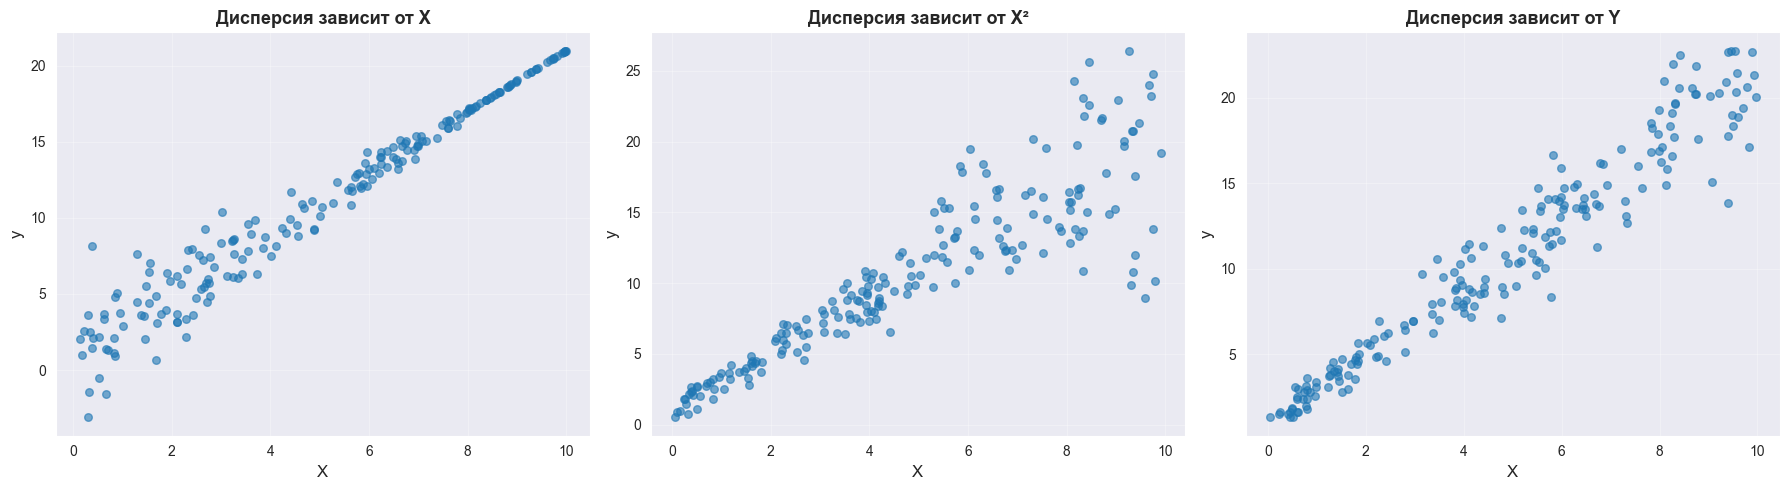

In [83]:
n = 200

# Тип 1: Дисперсия зависит от Х
X1 = np.random.uniform(0, 10, n)
sigma1 = 2.5 - np.clip(0.3 * X1, 0, 2.5)
y1 = 2 * X1 + 1 + np.random.normal(0, sigma1, n)

# Тип 2: Дисперсия зависит от квадрата X
X2 = np.random.uniform(0, 10, n)
sigma2 = 0.5 + 0.05 * X2**2
y2 = 2 * X2 + 1 + np.random.normal(0, sigma2, n)

# Тип 3: Дисперсия зависит от предсказанного значения Y
X3 = np.random.uniform(0, 10, n)
y_true3 = 2 * X3 + 1
sigma3 = 0.3 + 0.1 * np.abs(y_true3)
y3 = y_true3 + np.random.normal(0, sigma3, n)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (X, y, title) in enumerate([(X1, y1, 'Дисперсия зависит от X'),
                                     (X2, y2, 'Дисперсия зависит от X²'),
                                     (X3, y3, 'Дисперсия зависит от Y')]):
    axes[idx].scatter(X, y, alpha=0.6, s=30)
    axes[idx].set_xlabel('X', fontsize=12)
    axes[idx].set_ylabel('y', fontsize=12)
    axes[idx].set_title(title, fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


В этой части рассмотрим данные о стоимости домовладения. При этом будем использовать следующие признаки:
* Y = стоимость дома
* X1 = площадь дома
* X2 = площадь участка
Подмножество набора данных об исследовании американского сообщества, полученного из Бюро переписей США.

In [84]:
data = pd.read_csv(f"{data_path}/realestate.txt", sep="\t") # pd.read_csv(f"{data_path}/realestate.csv").dropna()

In [85]:
# Делаем доп.датасет со всеми положениями
linear_X, linear_y = datasets.make_regression(n_samples=data.shape[0],
                                              n_features=data.shape[1],
                                              noise=75, random_state=46)

# Setting feature names to x1, x2, x3, etc. if they are not defined
linear_feature_names = ['X'+str(feature+1) for feature in range(linear_X.shape[1])]

In [86]:
data.columns

Index(['SalePrice', 'SqFeet', 'Beds', 'Baths', 'Air', 'Garage', 'Pool', 'Year',
       'Quality', 'Style', 'Lot', 'Highway'],
      dtype='object')

In [87]:
X_train, X_test, y_train, y_test = train_test_split(data[["SqFeet"]], np.log(data["SalePrice"]))

In [ ]:

#X_train, X_test, y_train, y_test = train_test_split(data.drop(["Percent_Households_Below_Poverty_Level", "County"], axis=1), data["Percent_Households_Below_Poverty_Level"])

In [48]:
X_train

,SqFeet
511,1.424
191,2.958
505,2.377
490,1.604
102,5.032
...,...
427,1.644
451,1.760
94,2.705
88,3.648



Поскольку все переменные сильно асимметричны, мы сначала логарифмизируем каждую переменную. Затем, если провести регрессионный анализ и оценить график остатков в сравнении с предсказанными значениями, можно отметить несколько «коническую» форму остатков.

In [88]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

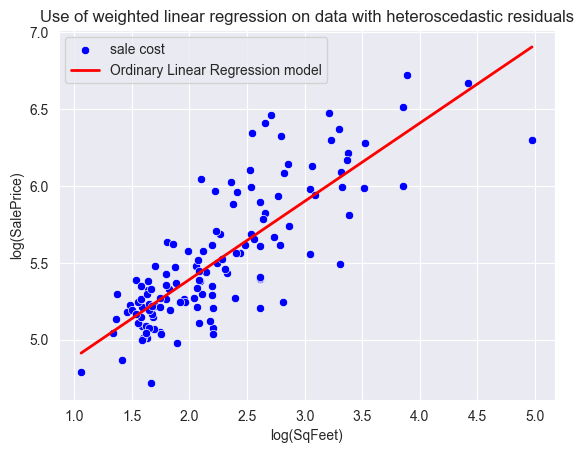

In [89]:
sns.scatterplot(x=X_test["SqFeet"], y=y_test, label='sale cost', color='blue')
sns.lineplot(x=X_test["SqFeet"], y=preds, label='Ordinary Linear Regression model', color='red', linewidth=2)
plt.xlabel('log(SqFeet)')
plt.ylabel('log(SalePrice)')
plt.legend()
plt.title(f'Use of weighted linear regression on data with heteroscedastic residuals')
plt.show()

In [51]:
print(f"The score of prediction is: {model.score(X_test, y_test)}")

The score of prediction is: 0.7160204204317404


Другой способ построить график остатков предлагает Sklearn

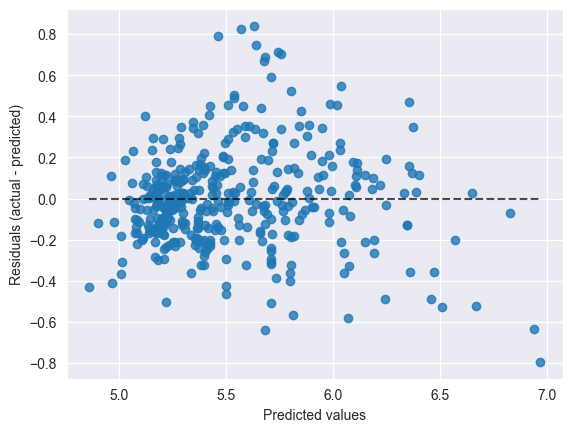

In [52]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_train, y_pred=model.predict(X_train))
display.plot()
plt.show()

Более объективную оценку могут дать специальные статистические тесты, например, тест Уайта или тест Брейша-Пагана

In [53]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import statsmodels.stats.diagnostic as smd

Тест Бреуша-Пагана  можно выполнить с помощью функции het_breuschpagan модуля statsmodels.stats.diagnostic для оценки того, объясняют ли независимые переменные дисперсию ошибок. 

Основные параметры функции het_breuschpagan resid - остатки модели, а exog_het — независимые переменные. Обратите внимание, что ему нужна также константная переменная. 
Этот тест проверяет нулевую гипотезу о том, что все дисперсии ошибок равны, в сравнении с альтернативой, согласно которой дисперсии ошибок являются мультипликативной функцией одной или нескольких переменных. Этот тест затрагивает линейную форму гетероскедастичности.

Тест Уайта (het_white) оценивает то, объясняют ли независимые переменные линейной регрессии, квадратичные независимые переменные и перемножения независимых переменных дисперсию ошибок. Он не накладывает ограничений на форму гетероскедастичности.  Внутри происходит регрессия квадратов остатков по отношению к исходным переменным, их квадратам и попарным произведениям. Он более общий как раз из-за добавления дополнительных переменных. Например, квадраты позволяют найти гетероскедастичность в форме "песочных часов". Однако, у него есть минус в том, что исходная гипотеза разбивается на несколько.

**Вопрос**: почему это минус? Укажите теоретическую причину.


Основные параметры в функции het_white resid - остатки, а exog - независимые переменные для объяснения дисперсии ошибок модели. 

Выполним тесты для нашего датасета, чтобы понять, реально ли в модели присутствует гетероскедастичность.

In [54]:
def get_residual_df(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = df_results['Actual'] - df_results['Predicted']
    
    return df_results


In [55]:
res_train = get_residual_df(model, X_train, y_train)
res_test = get_residual_df(model, X_test, y_test)

In [56]:
X_test_new = X_test.copy()
X_test_new["const"]=1.

In [57]:
bptest = smd.het_breuschpagan(resid=res_test["Residuals"], exog_het=X_test_new)
print("lm:", bptest[0], "lm_pvalue:", bptest[1])

lm: 4.079032002230588 lm_pvalue: 0.04341852589058567


**Вопрос**: что означает pvalue? Можем ли мы сказать, что остатки гетероскедачстичны?

p_value - пороговое значение для принятия/отклонения проверяемой гипотезы. Нулевая гипотеза - гомоскедастичность. Если lm > pvalue, нулевая гипотеза принимается.

In [58]:
wtest = smd.het_white(resid=res_test["Residuals"], exog=X_test_new)
print("lm:", wtest[0], "lm_pvalue:", wtest[1])

lm: 5.512489216749302 lm_pvalue: 0.06352990059653195


### Решение проблемы
**Вопрос**: Как можно избавиться от гетероскедастичности (или уменьшить ее влияние)? 


### Обобщенная линейная модель
Линейная модель описывается уравнением $\textbf{Y}=\textbf{X}\beta+\epsilon^{*}$.

При этом $ \epsilon^{*} $ распределены нормально с нулевым средним и изменяющейся дисперсией:
\begin{equation*} \left(\begin{array}{cccc} \sigma^{2}_{1} & 0 & \ldots & 0 \\ 0 & \sigma^{2}_{2} & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \sigma^{2}_{n} \\ \end{array} \right) \end{equation*}
Тогда мы можем определить веса $ w_i = 1/\sigma^{2}_{i} $ так чтобы
\begin{equation*}\textbf{W}=\left( \begin{array}{cccc} w_{1} & 0 & \ldots & 0 \\ 0& w_{2} & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0& 0 & \ldots & w_{n} \\ \end{array} \right) \end{equation*}


Поскольку каждый вес обратно пропорционален дисперсии ошибки, он отражает информацию, содержащуюся в этом наблюдении. Итак, наблюдение с небольшой дисперсией ошибки имеет большой вес, поскольку оно содержит относительно больше информации, чем наблюдение с большой дисперсией ошибки (малый вес).
Веса должны быть известны (или, чаще всего, оценены) с точностью до константы пропорциональности.

Тогда можно поставить задачу взвешенной регрессиии $\sum_{i=1}^n w_i^2(y_i - (\alpha 1 + \beta x_i))^2 = \sum_{i=1}^n (w_i y_i - (\alpha w_i + \beta w_i x_i))^2
$


Финальная модель называется White’s Heteroskedasticity Consistent Estimator https://www.hbs.edu/research-computing-services/Shared%20Documents/Training/hac.pdf

Так как остатки в нашей задаче зависят от величины признака X, мы можем предсказать их по этому признаку.

**Задание**: Постройте взвешенную модель, учитывающую гетероскедастичность. Для построения весов используйте аппроксимацию дисперсии ошибки.

In [59]:
add_x_train = model.predict(X_train)
add_x_test = model.predict(X_test)
# log is used to force all estimates to be positive
add_y_train = np.sqrt(np.abs(model.predict(X_train) - y_train))
add_y_test = np.sqrt(np.abs(model.predict(X_test) - y_test))

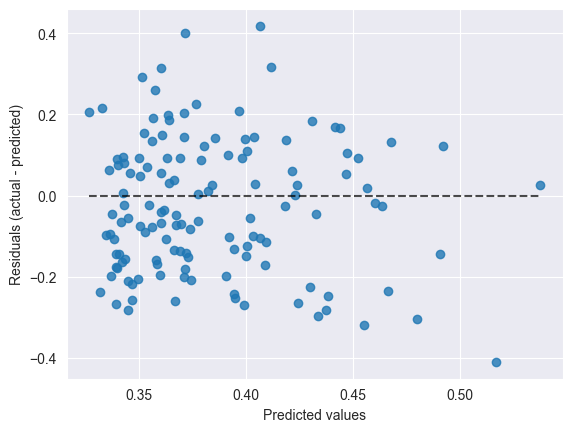

In [60]:
weight_regressor = LinearRegression().fit(X_train, add_y_train)
residual_estimates_train = weight_regressor.predict(X_train)
residual_estimates_test = weight_regressor.predict(X_test)
display = PredictionErrorDisplay(y_true=add_y_test, y_pred=residual_estimates_test)
display.plot()
plt.show()

In [61]:
weights_train = np.sqrt(1/(residual_estimates_train**2))
weights_test = np.sqrt(1/(residual_estimates_test**2))

In [62]:
weights_train = 1 / ((residual_estimates_train))
weights_test = 1 / ((residual_estimates_test))

In [63]:
updated_model = LinearRegression().fit(X_train, y_train, weights_train)
updated_preds = updated_model.predict(X_test)

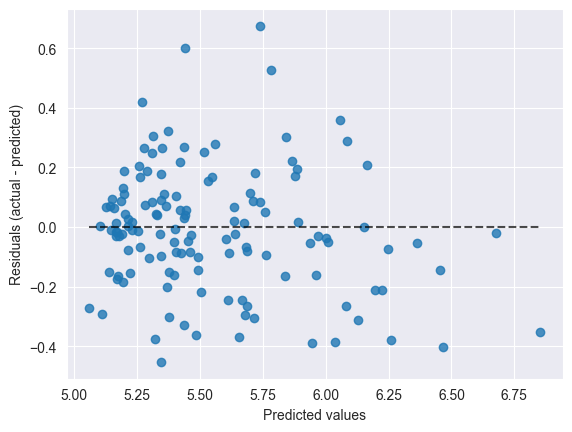

In [64]:
display = PredictionErrorDisplay(
    y_true=y_test, y_pred = updated_preds
    )
display.plot()
plt.show()

In [65]:
print(f"The score of prediction is: {updated_model.score(X_test, y_test)}")

The score of prediction is: 0.7118901657094349


In [66]:
X_test_new = X_test.copy()
X_test_new["const"]=1.

In [67]:
bptest = smd.het_breuschpagan(resid=(y_test-updated_preds), exog_het=X_test_new)
print("lm:", bptest[0], "lm_pvalue:", bptest[1])

lm: 5.316583495624419 lm_pvalue: 0.021123387922938372


In [68]:
wtest = smd.het_white(resid=(y_test-updated_preds), exog=X_test_new)
print("lm:", wtest[0], "lm_pvalue:", wtest[1])

lm: 6.195354535833089 lm_pvalue: 0.04515396123755682


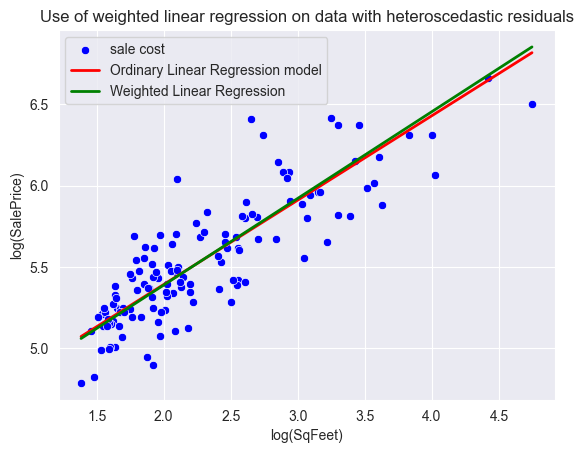

In [69]:
sns.scatterplot(x=X_test["SqFeet"], y=y_test, label='sale cost', color='blue')
sns.lineplot(x=X_test["SqFeet"], y=preds, label='Ordinary Linear Regression model', color='red', linewidth=2)
sns.lineplot(x=X_test["SqFeet"], y=updated_preds, label='Weighted Linear Regression', color='green', linewidth=2)
plt.xlabel('log(SqFeet)')
plt.ylabel('log(SalePrice)')
plt.legend()
plt.title(f'Use of weighted linear regression on data with heteroscedastic residuals')
plt.show()

In [70]:
from sklearn.metrics import r2_score

print(f"R^2: {r2_score(y_test, preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, preds):.4f}")


R^2: 0.7160
MSE: 0.0423


### Box-Cox
При неизвестном типе распределения одним из лучших методов приведения распределения к нормальному является преобразование Бокса-Кокса. Суть метода заключается в преобразовании переменной с помощью параметра $\lambda$ так, что:

$ \hat{y_i} = { {y^\lambda}_i \over {\lambda}}$ - если $\lambda \neq 0 $

$ \hat{y_i} = log(y_i) $ - если $\lambda = 0 $

Параметр $\lambda$ подбирается с помощью максимизации логарифма правдоподобия.

In [71]:
def boxcox_transform(y, lmbda):
    if lmbda == 0:
        return np.log(y)
    else:
        return (y**lmbda - 1) / lmbda

def inverse_boxcox(y_transformed, lmbda):
    if lmbda == 0:
        return np.exp(y_transformed)
    else:
        return (lmbda * y_transformed + 1)**(1/lmbda)


In [72]:

from scipy.stats import boxcox

# делаем все значения строго положительными и находим лучшую лямбду
y_min_train = y_train.min() 
y_boxcox_pos = y_train - y_min_train + 1
y_transformed, fitted_lambda = boxcox(y_boxcox_pos)
print(f"fitted lambda: {fitted_lambda:.4f}")


fitted lambda: -0.2659


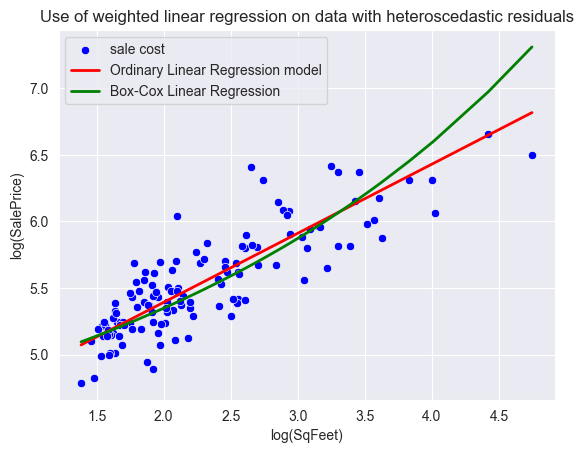

In [73]:
box_cox_model = LinearRegression()
box_cox_model.fit(X_train, y_transformed)

# Получаем предсказания в преобразованном пространстве и обратно преобразуем
box_cox_preds = inverse_boxcox(box_cox_model.predict(X_test), fitted_lambda) + y_min_train - 1

sns.scatterplot(x=X_test["SqFeet"], y=y_test, label='sale cost', color='blue')
sns.lineplot(x=X_test["SqFeet"], y=preds, label='Ordinary Linear Regression model', color='red', linewidth=2)
sns.lineplot(x=X_test["SqFeet"], y=box_cox_preds, label='Box-Cox Linear Regression', color='green', linewidth=2)
plt.xlabel('log(SqFeet)')
plt.ylabel('log(SalePrice)')
plt.legend()
plt.title(f'Use of weighted linear regression on data with heteroscedastic residuals')
plt.show()

In [74]:
from sklearn.metrics import r2_score

print(f"R^2: {r2_score(y_test, box_cox_preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, box_cox_preds):.4f}")


R^2: 0.6496
MSE: 0.0522


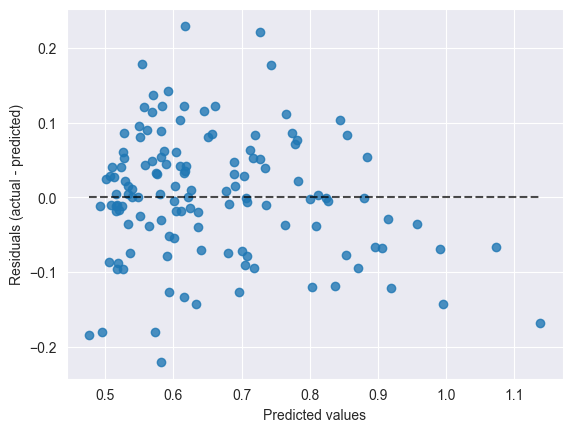

In [75]:
display = PredictionErrorDisplay(
    y_true = boxcox_transform(y_test - y_min_train + 1, fitted_lambda),
    y_pred = box_cox_model.predict(X_test)
    )
display.plot()
plt.show()

### Квантильная регрессия

В нашем случае остатки линейной регрессии симметричны, поэтому мы можем легко перейти на квантильную регрессиию, которая позволяет оценить заданные квантили таргета. Этот регрессор минимизирует MAE, в отличие от стандартной регрессии.

Вопрос: Почему он минимизирует MAE?


In [76]:
from sklearn.linear_model import QuantileRegressor

In [77]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions_test = np.zeros_like(y_test, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X_train, y_train).predict(X_test)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions_test = np.logical_or(
            out_bounds_predictions_test, y_pred >= y_test
        )
    elif quantile == max(quantiles):
        out_bounds_predictions_test = np.logical_or(
            out_bounds_predictions_test, y_pred <= y_test
        )

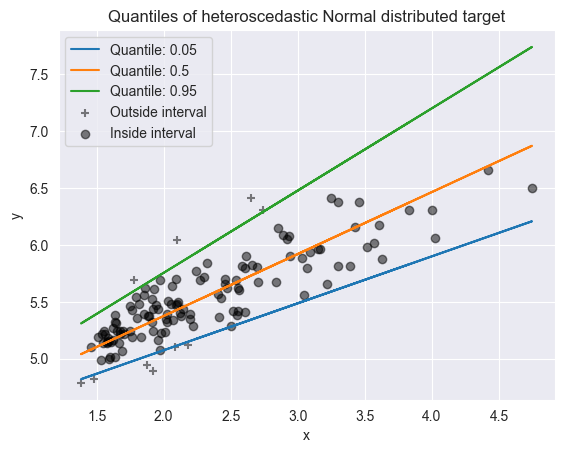

In [78]:
for quantile, y_pred in predictions.items():
    plt.plot(X_test, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    X_test[out_bounds_predictions_test],
    y_test[out_bounds_predictions_test],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    X_test[~out_bounds_predictions_test],
    y_test[~out_bounds_predictions_test],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")


Почитать: https://www3.nd.edu/~rwilliam/stats2/l25.pdf

**Задание**: Постройте модели, учитывающие гетероскедастичность  для  Anscombe 3 и 4. Предложите сами, как вы будете задавать веса.

**Задание**: Постройте синтетические данные, подходящие для линейной модели. Покажите, поможет ли использование QuantileRegressor для удаления выбросов получить лучшую модель и для каких видов гетероскедастичности (выбросы, распределение, "форма" шума)

### Преобразования переменных

Иногда гетероскедастичность можно устранить простыми преобразованиями переменных.

**Логарифмическое преобразование**:

Часто используется, когда дисперсия пропорциональна квадрату среднего значения:

$$\text{Var}(Y | X) \propto [E(Y | X)]^2$$

После логарифмирования: $\text{Var}(\ln Y | X) \approx \text{const}$

**Квадратный корень**:

Полезно, когда дисперсия пропорциональна среднему:

$$\text{Var}(Y | X) \propto E(Y | X)$$

После преобразования: $\text{Var}(\sqrt{Y} | X) \approx \text{const}$


## Проверка нормальности остатков

Одним из важных предположений линейной регрессии является **нормальность распределения ошибок**. Это предположение необходимо для:
- Корректного построения доверительных интервалов для коэффициентов
- Проведения статистических тестов (t-тесты, F-тесты)
- Получения эффективных оценок методом наименьших квадратов (теорема Гаусса-Маркова)
- Качественной интерпретации результатов

Для проверки нормальности остатков используются:
1. **Визуальные методы**: Q-Q plots (квантиль-квантиль графики), гистограммы
2. **Статистические тесты**: Shapiro-Wilk (для малых выборок), Jarque-Bera (для больших выборок)

### Визуальная проверка нормальности

Q-Q plot (quantile-quantile plot) сравнивает квантили остатков с квантилями нормального распределения. Если остатки нормально распределены, точки должны лежать примерно на прямой линии.


In [79]:
from scipy import stats
def plot_normality_check(residuals, title="Проверка нормальности остатков"):
    residuals = np.array(residuals)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[0])
    axes[0].set_title('Q-Q Plot (Quantile-Quantile Plot)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Теоретические квантили', fontsize=12)
    axes[0].set_ylabel('Выборочные квантили', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # 2. Гистограмма остатков с наложенным нормальным распределением
    axes[1].hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black', label='Остатки')
    
    # Наложим нормальное распределение с теми же параметрами
    mu, sigma = np.mean(residuals), np.std(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Нормальное распределение')
    axes[1].set_xlabel('Остатки', fontsize=12)
    axes[1].set_ylabel('Плотность', fontsize=12)
    axes[1].set_title('Гистограмма остатков', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()



**Статистические тесты:**
- **Shapiro-Wilk test**: подходит для выборок размером до 5000 наблюдений. Нулевая гипотеза: остатки распределены нормально. Если p-value > 0.05, мы не можем отвергнуть гипотезу о нормальности.
- **Jarque-Bera test**: подходит для больших выборок. Проверяет нормальность на основе асимметрии и эксцесса. Нулевая гипотеза: остатки распределены нормально.


In [80]:
from scipy.stats import shapiro, jarque_bera

def test_normality(residuals, alpha=0.05, use_shapiro: bool = True):
    """ Используйте тест Шапиро-Уилка, если маленькая выборка"""
    residuals = np.array(residuals)
    
    if use_shapiro:
        shapiro_stat, shapiro_p = shapiro(residuals)
        results = {
            'statistic': shapiro_stat,
            'p_value': shapiro_p,
            'is_normal': shapiro_p > alpha
        }
        print(f"Shapiro-Wilk test:")
        print(f"  Statistic: {shapiro_stat:.4f}")
        print(f"  p-value: {shapiro_p:.4f}")
        print(f"  Нормальность: {'Да' if shapiro_p > alpha else 'Нет'}")
    else:
        # Тест Жарке-Бера (для больших выборок)
        jb_stat, jb_p = jarque_bera(residuals)
        results = {
            'statistic': jb_stat,
            'p_value': jb_p,
            'is_normal': jb_p > alpha
        }
        print(f"\nJarque-Bera test:")
        print(f"  Statistic: {jb_stat:.4f}")
        print(f"  p-value: {jb_p:.4f}")
        print(f"  Нормальность: {'Да' if jb_p > alpha else 'Нет'}")
        
    return results


Проверим нормальность для модели, которая была построена ранее в разделе о гетероскедастичности.


C:\Users\Roman\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


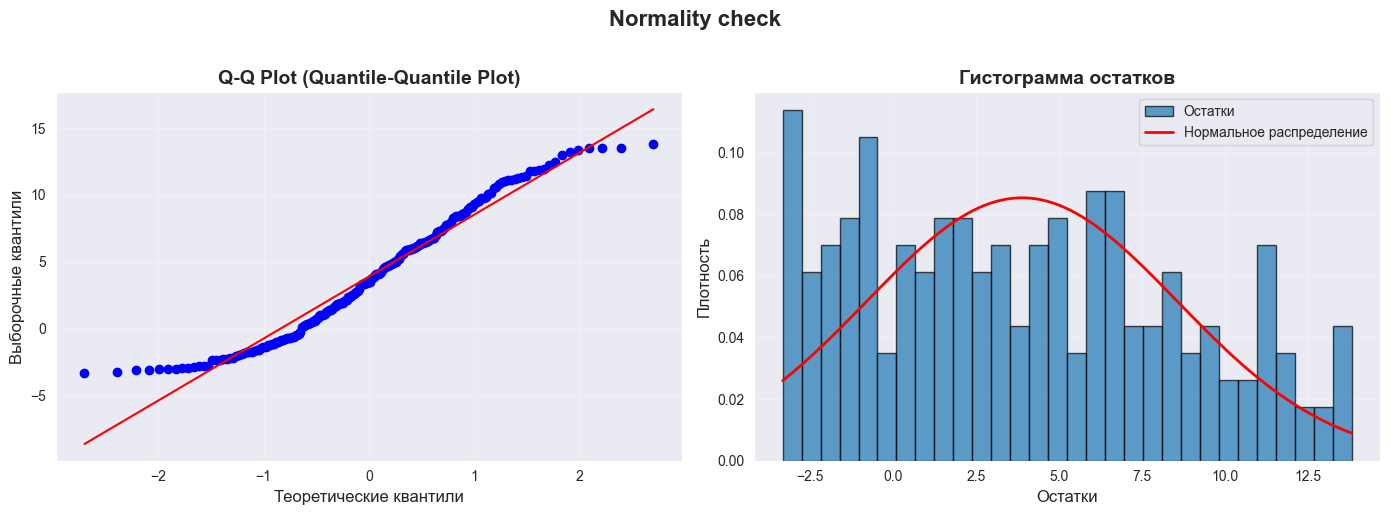

In [91]:
y_pred = model.predict(X.reshape(-1, 1))
residuals = y - y_pred

plot_normality_check(residuals, title="Normality check")


In [92]:
# Статистические тесты
print("\nСтатистические тесты:")
print("-" * 60)
test_results = test_normality(residuals)

# Дополнительная статистика
print(f"\nДополнительная статистика:")
print(f"  Среднее остатков: {np.mean(residuals):.6f}")
print(f"  Медиана остатков: {np.median(residuals):.6f}")
print(f"  Стандартное отклонение: {np.std(residuals):.6f}")
print(f"  Асимметрия (skewness): {stats.skew(residuals):.4f}")
print(f"  Эксцесс (kurtosis): {stats.kurtosis(residuals):.4f}")


Статистические тесты:
------------------------------------------------------------
Shapiro-Wilk test:
  Statistic: 0.9575
  p-value: 0.0000
  Нормальность: Нет

Дополнительная статистика:
  Среднее остатков: 3.886638
  Медиана остатков: 3.458308
  Стандартное отклонение: 4.675894
  Асимметрия (skewness): 0.2943
  Эксцесс (kurtosis): -0.9560


### Интерпретация результатов

**Q-Q plot:**
- Если точки лежат близко к прямой линии, остатки распределены нормально
- Отклонения от прямой указывают на отклонение от нормальности
- S-образная кривая указывает на асимметрию распределения
- Выпуклость/вогнутость указывает на тяжелые/легкие хвосты распределения

**Важно:** Нарушение нормальности остатков не всегда критично для предсказательной способности модели, но может влиять на статистические выводы (доверительные интервалы, p-значения).


## Мультиколлинеарность

Мультиколлинеарность представляет собой проблему, поскольку она дает менее надежные результаты регрессионной модели. Это связано с более широкими доверительными интервалами (большими стандартными ошибками), которые могут снизить статистическую значимость коэффициентов регрессии. При анализе данных это может привести к ложным впечатлениям.

Рассмотрим уже знакомый нам набор данных, посвященный недвижимости.

In [93]:
data = pd.read_csv(f"{data_path}/realestate.txt", sep="\t")

In [94]:
data["SalePrice"] = np.log(data["SalePrice"])
data.describe()

,SalePrice,SqFeet,Beds,Baths,Air,Garage,Pool,Year,Quality,Style,Lot,Highway
count,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000
mean,5.525443,2.260879,3.477927,2.646833,0.831094,2.097889,0.069098,1966.856046,2.186180,3.349328,24.344668,0.021113
std,0.430851,0.711726,1.003835,1.058861,0.375029,0.653405,0.253864,17.620476,0.639923,2.563209,11.681280,0.143900
min,4.430817,0.980000,1.000000,1.000000,0.000000,0.000000,0.000000,1885.000000,1.000000,1.000000,4.560000,0.000000
25%,5.192957,1.701000,3.000000,2.000000,1.000000,2.000000,0.000000,1956.000000,2.000000,1.000000,17.159000,0.000000
50%,5.437644,2.061000,3.000000,3.000000,1.000000,2.000000,0.000000,1966.000000,2.000000,2.000000,22.196000,0.000000
75%,5.814131,2.638000,4.000000,3.000000,1.000000,2.000000,0.000000,1981.000000,3.000000,7.000000,26.777000,0.000000
max,6.824374,5.032000,7.000000,7.000000,1.000000,7.000000,1.000000,1998.000000,3.000000,11.000000,86.830000,1.000000


Обучим базовую модель на одном признаке.

In [95]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.696237587585443
Coefficients are: [0.50970481]


Теперь добавим несколько видов мультиколлинеарности в данных.

### Совершенная коллинеарность

Если две или более независимых переменных имеют между собой линейную связь, то
у нас получается идеальная мультиколлинеарность.
Примеры: включение одной и той же информации дважды (стоимость в рублях и долларах), неправильное использование фиктивных переменных (dummy variables trap) и т. д.
Вот пример идеальной мультиколлинеарности в модели с двумя объясняющими
переменными:
\begin{equation}
y = α_{1} X_1 + \alpha_{2} X_2
\end{equation}
\begin{equation}
X_1 = \beta_1 X_2 + \beta_2
\end{equation}


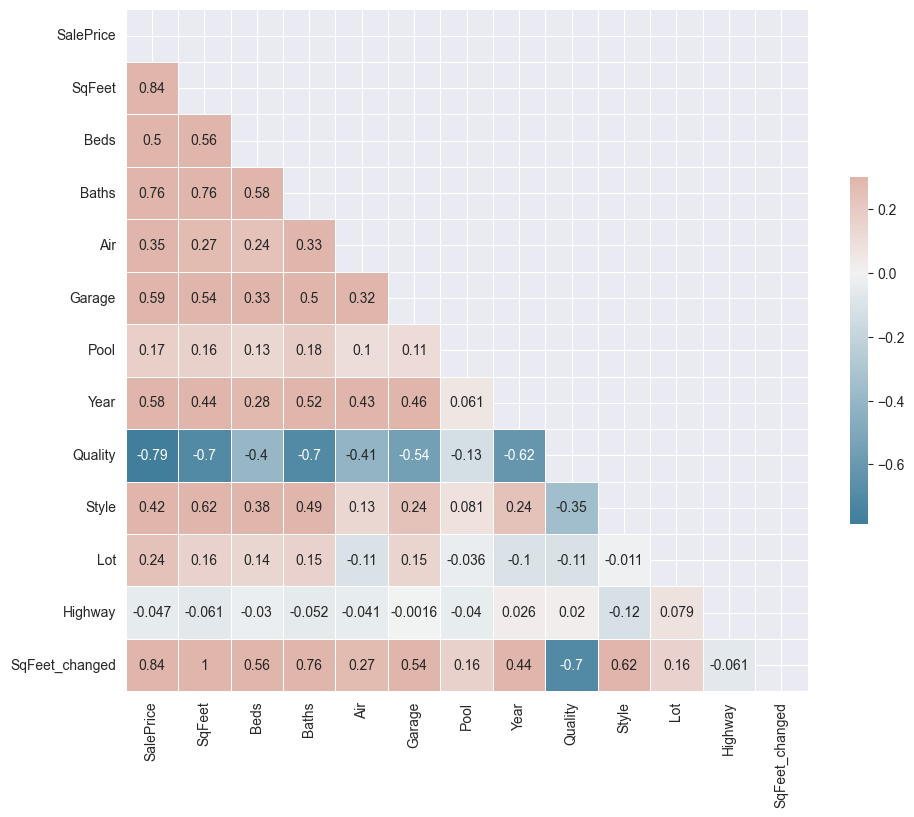

In [96]:
data["SqFeet_changed"] = data["SqFeet"]* 0.8 + 10
corrplot(data)

In [97]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6962375875854426
Coefficients are: [0.24863649 0.31079562]


In [98]:
data["SqFeet_changed_2"] = data["SqFeet"]* 0.5 - 10
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet_changed_2", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6962375875854427
Coefficients are: [0.21574807 0.13484254 0.26968508]


По идее, совершенная коллинеарность не дает в принципе построить линейную модель, так как невозможно оценить маржинальный эффект воздействия признака на целевую переменную, сохраняя остальные константными.
)
На практике же, даже если конкретная реализация OLS позволит построить коэффициенты, это ведет к тому, что модель перестает быть устойчивой.

### Несовершенная мультиколлинеарность
Несовершенная мультиколлинеарность не нарушает базовых предположений ЛР. Следовательно, теорема Гаусса-Маркова говорит нам, что оценки МНК состоятельны.

Так почему же нас волнует мультиколлинеарность?
2. Дисперсия и стандартные ошибки оценок коэффициентов регрессии будут
увеличиваться. Это означает более низкую t-статистику.
3. На общую точность уравнения регрессии мультиколлинеарность практически не повлияет.
4. Коэффициенты регрессии будут сильно зависеть от признаков. Таким образом, коэффициенты существенно измениться при добавлении или удалении переменных.

In [99]:
data["SqFeet_changed"] = data["SqFeet"] * 0.8 - 20
data["SqFeet_changed_2"] = data["SqFeet_changed"] * 1.5 + 10

data["SqFeet_changed"] += np.random.normal(+1, 0.5, len(data["SqFeet_changed"]))
data["SqFeet_changed_2"] += np.random.normal(-1, 0.5, len(data["SqFeet_changed"]))


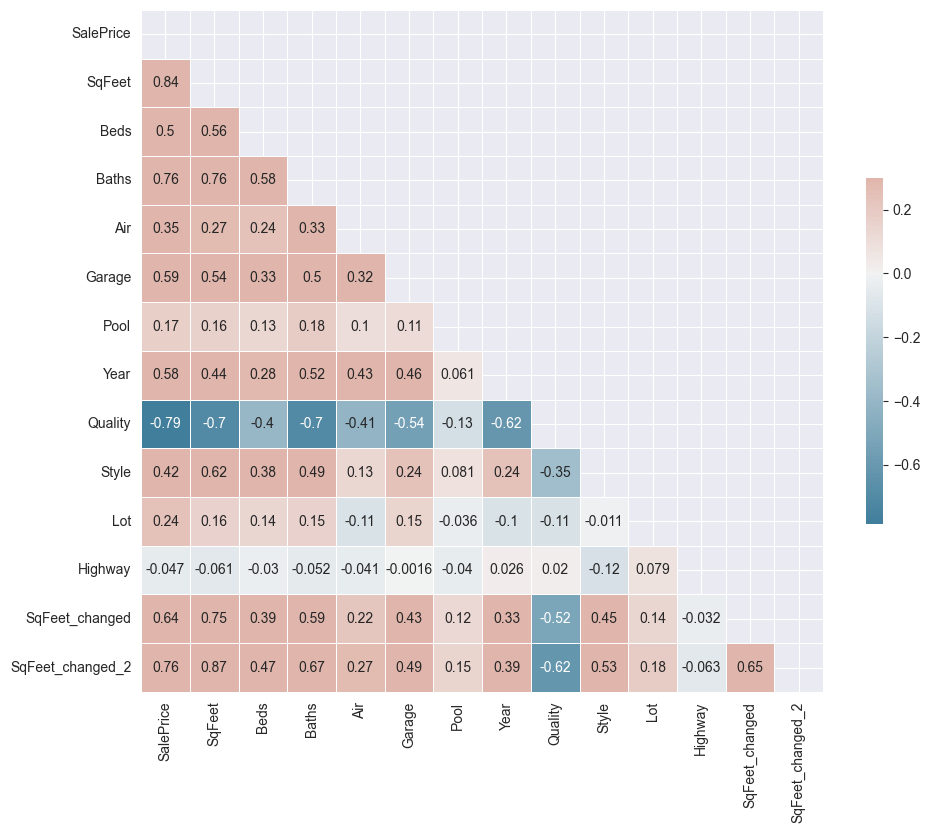

In [100]:
corrplot(data)

In [101]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet_changed_2", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6937580485945061
Coefficients are: [0.01444629 0.05193253 0.43569631]


In [102]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.6965968240369946
Coefficients are: [0.01345402 0.49956276]


Как видно, только один признак имеет большой вес, точность при этом практически не меняется. Однако значимость многих признаков становится неудовлетворительной. Поэтому, если оценить значимость коэффициентов модели, можно обнаружить, что многие признаки просто не нужны. При этом получается, что даже при очень небольшом изменении модели мы можем сделать совершенно противоположные выводы о том, какие признаки важны.

Итак, первый способ найти коллинеарные признаки - оценить значимость коэффициентов (t-statistic + p-value)

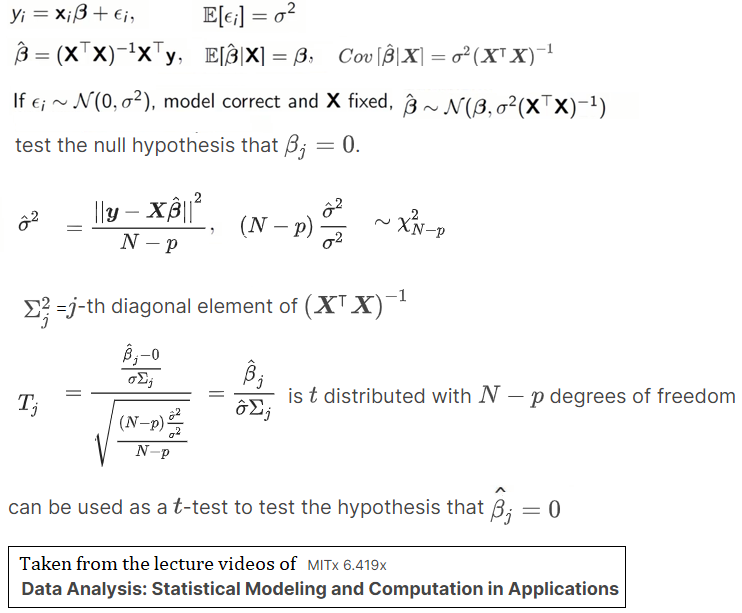

In [103]:
from scipy.stats import t

**Задание**: Закончите функцию.

In [ ]:
def get_p_values(model, x: pd.DataFrame, y: pd.DataFrame, a: int = 0.01) -> None:
  beta_hat = [model.intercept_] + model.coef_.tolist()
  n = len(x)
  print(f"Coeffficents: {beta_hat}")
  x_1 = np.column_stack((np.ones(n), x))
  # standard deviation of the noise.
  sigma_hat = np.sqrt(np.sum(np.square(y - x_1@beta_hat)) / (n - x_1.shape[1]))
  # estimate the covariance matrix for beta
  beta_cov = np.linalg.inv(x_1.T@x_1)
  # the t-test statistic for each variable from the formula from above figure
  t_vals = beta_hat / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
  # compute 2-sided p-values.
  p_vals = t.sf(np.abs(t_vals), n-x_1.shape[1])*2
  print(f"T values: {t_vals}")
  print(f"p-values: {p_vals}")
  print(f"Is valuable: {p_vals > 0.01}")

In [ ]:
def get_p_values(model, x: pd.DataFrame, y: pd.DataFrame, a: int = 0.01) -> None:
  beta_hat = [model.intercept_] + model.coef_.tolist()
  n = len(x)
  print(f"Coeffficents: {beta_hat}")
  x_1 = np.column_stack((np.ones(n), x))
  # standard deviation of the noise.
  sigma_hat = # CAlculate the noise
  # estimate the covariance matrix for beta
  beta_cov = # Get (X^TX)^-1
  # the t-test statistic for each variable from the formula from above figure
  t_vals =  # your code: beta_hat / (sigma_hat * sqrt(diagonal(beta_cov)))
  # compute 2-sided p-values.
  p_vals = t.sf(np.abs(t_vals), n-x_1.shape[1])*2
  print(f"T values: {t_vals}")
  print(f"p-values: {p_vals}")
  print(f"Is valuable: {p_vals > 0.01}")

In [ ]:
get_p_values(model, x_test, y_test)

Мультиколлинеарность можно обнаружить и с помощью коэффициента инфляции дисперсии (VIF). Для каждого признака в построенной модели этот коэффициент показывает, в какой степени коэфициент "испорчен" коллинеарностью с другими признаками.

В методе VIF мы выбираем каждый признак и сравниваем его со всеми другими признаками. Для каждого признака коэффициент рассчитывается как:

image.png
где R-квадрат — коэффициент детерминации в линейной регрессии этого признака, построенной по всем остальным признакам (1-to-all). Его значение лежит между 0 и 1.
Как мы видим из формулы, чем больше значение R-квадрат, тем больше VIF. Следовательно, больший VIF означает большую корреляцию. Это согласуется с тем фактом, что более высокое значение R-квадрат означает более сильную коллинеарность. Обычно значение VIF выше 5 указывает на высокую мультиколлинеарность.


In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]

print(vif_data)

          feature      VIF
0  SqFeet_changed  9.62725
1          SqFeet  9.62725


Как мы видим, наши переменные имеют очень высокие значения VIF, что означает сильную коллинеарность между ними.


In [105]:
features = ['SqFeet', 'Beds', 'Baths', 'Air', 'Garage', 'Pool', 'Year',
       'Quality', 'Style', 'Lot', 'Highway']

In [106]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[features], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Model score is: 0.8333627167756659
Coefficients are: [ 0.32128686  0.01746661  0.05093416  0.00689765  0.03780231  0.03515141
  0.0033515  -0.11809948 -0.01708504  0.00487232 -0.06529713]


In [107]:
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [ # Calculate vif for each feature in data]
vif_data

SyntaxError: incomplete input (611618864.py, line 6)

Теперь можно удалить некоторые признаки. Для этого используются разные способы feature selection. Посмотрим, узменится ли предсказание при удалении некоторых признаков

**Задание**: Постройте модель, удалив лишние признаки. Можно ли получить модель с лучшим скором?

In [ ]:
# Your code